<a href="https://colab.research.google.com/github/keerthireddy-28/ExplainableAi/blob/main/Plant_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant disease prediction

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
!pip install lime shap pdpbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=333ab8339297ab2414dbf2a090f0b385f93ff75bf591ff233ff3f7de610d813a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [1]:
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from pdpbox import pdp


In [6]:
import os
import random
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


data_dir = '/content/drive/MyDrive/archive (2)'

train_dir = os.path.join(data_dir, 'Train/Train')
test_dir = os.path.join(data_dir, 'Test/Test')
val_dir = os.path.join(data_dir, 'Validation/Validation')

def load_dataset(base_dir):
    image_paths, labels = [], []
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(label_path, file))
                    labels.append(label)
    return pd.DataFrame({'image_path': image_paths, 'label': labels})

train_df = load_dataset(train_dir)
test_df = load_dataset(test_dir)
val_df = load_dataset(val_dir)

print("Dataset Loaded Successfully!")
print(f"Train: {train_df.shape}, Test: {test_df.shape}, Validation: {val_df.shape}")

Dataset Loaded Successfully!
Train: (1333, 2), Test: (152, 2), Validation: (63, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  1333 non-null   object
 1   label       1333 non-null   object
dtypes: object(2)
memory usage: 21.0+ KB
None

Missing Values:
 image_path    0
label         0
dtype: int64

Number of Classes: 3
label
Healthy    469
Rust       434
Powdery    430
Name: count, dtype: int64


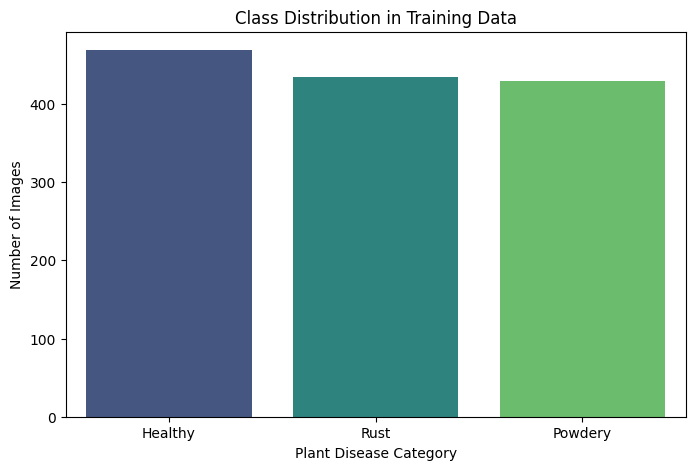

In [7]:
print(train_df.info())
print("\nMissing Values:\n", train_df.isnull().sum())
print("\nNumber of Classes:", train_df['label'].nunique())
print(train_df['label'].value_counts())
plt.figure(figsize=(8,5))
sns.countplot(x='label', data=train_df, order=train_df['label'].value_counts().index, palette='viridis')
plt.title('Class Distribution in Training Data')
plt.xlabel('Plant Disease Category')
plt.ylabel('Number of Images')
plt.show()


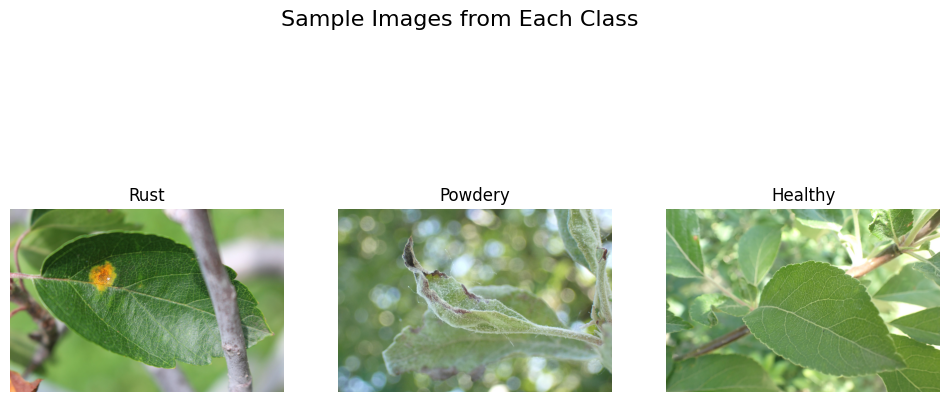

In [8]:
plt.figure(figsize=(12, 6))
classes = train_df['label'].unique()
for i, cls in enumerate(classes):
    sample_path = random.choice(train_df[train_df['label'] == cls]['image_path'].values)
    img = Image.open(sample_path)
    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


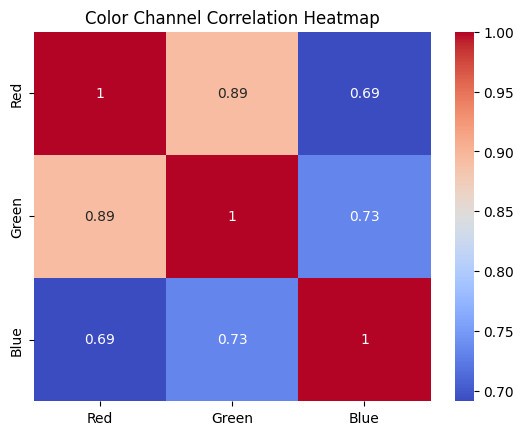

In [11]:
features = []
for path in tqdm(train_df['image_path'][:300]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    mean_color = img.mean(axis=(0,1))
    features.append(mean_color)

feature_df = pd.DataFrame(features, columns=['Red', 'Green', 'Blue'])
sns.heatmap(feature_df.corr(), annot=True, cmap='coolwarm')
plt.title("Color Channel Correlation Heatmap")
plt.show()


In [16]:


import tensorflow as tf

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



Found 1333 files belonging to 3 classes.
Found 63 files belonging to 3 classes.
Found 152 files belonging to 3 classes.


In [22]:
def extract_rgb_features(df, img_size=(64,64)):
    features = []
    for path in tqdm(df['image_path']):
        img = Image.open(path).convert('RGB')
        img = img.resize(img_size)
        img_array = np.array(img)
        mean_rgb = img_array.mean(axis=(0,1))
        features.append(mean_rgb)
    return np.array(features)


X_train_rf = extract_rgb_features(train_df)
X_test_rf = extract_rgb_features(test_df)
X_val_rf = extract_rgb_features(val_df)

le = LabelEncoder()
y_train_rf = le.fit_transform(train_df['label'])
y_test_rf = le.transform(test_df['label'])
y_val_rf = le.transform(val_df['label'])


scaler = StandardScaler()
X_train_rf = scaler.fit_transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)
X_val_rf = scaler.transform(X_val_rf)

print("Random Forest Preprocessing Done!")

100%|██████████| 63/63 [00:13<00:00,  4.81it/s]

Random Forest Preprocessing Done!


Train Accuracy: 1.0000
Validation Accuracy: 0.6032
Test Accuracy: 0.6382

Classification Report (Test Data):
              precision    recall  f1-score   support

     Healthy       0.57      0.67      0.62        52
     Powdery       0.69      0.62      0.65        50
        Rust       0.67      0.62      0.65        50

    accuracy                           0.64       152
   macro avg       0.65      0.64      0.64       152
weighted avg       0.64      0.64      0.64       152



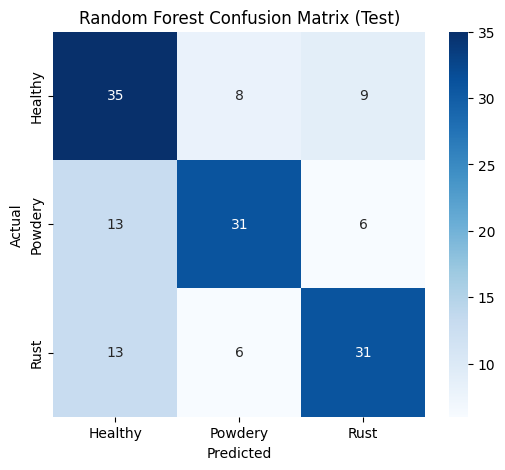

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train
rf_model.fit(X_train_rf, y_train_rf)

y_pred_train = rf_model.predict(X_train_rf)
y_pred_val   = rf_model.predict(X_val_rf)
y_pred_test  = rf_model.predict(X_test_rf)

train_acc = accuracy_score(y_train_rf, y_pred_train)
val_acc   = accuracy_score(y_val_rf, y_pred_val)
test_acc  = accuracy_score(y_test_rf, y_pred_test)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print("\nClassification Report (Test Data):")
print(classification_report(y_test_rf, y_pred_test, target_names=le.classes_))
cm = confusion_matrix(y_test_rf, y_pred_test)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix (Test)')
plt.show()

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get the number of classes from the original DataFrame
num_classes = train_df['label'].nunique()

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,699 (24.86 MB)

 Trainable params: 6,517,251 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6126 - loss: 5.4039

42/42 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.6144 - loss: 5.3718 - val_accuracy: 0.4127 - val_loss: 6.1529
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.8482 - loss: 0.9659 - val_accuracy: 0.2857 - val_loss: 4.5987
Epoch 3/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9077 - loss: 0.3946

42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9078 - loss: 0.3945 - val_accuracy: 0.5714 - val_loss: 2.9880
Epoch 4/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9276 - loss: 0.2528 - val_accuracy: 0.3810 - val_loss: 4.1489
Epoch 5/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9559 - loss: 0.1307 - val_accuracy: 0.5397 - val_loss: 3.9941
Epoch 6/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9591 - loss: 0.1502

42/42 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9591 - loss: 0.1504 - val_accuracy: 0.6984 - val_loss: 2.1799
Epoch 7/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9670 - loss: 0.1336

42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9669 - loss: 0.1336 - val_accuracy: 0.7302 - val_loss: 2.4524
Epoch 8/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9690 - loss: 0.1041 - val_accuracy: 0.4762 - val_loss: 8.4091
Epoch 9/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9727 - loss: 0.0779 - val_accuracy: 0.6349 - val_loss: 4.0516
Epoch 10/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9863 - loss: 0.0425 - val_accuracy: 0.7143 - val_loss: 2.4963
Epoch 11/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9745 - loss: 0.0683

42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9745 - loss: 0.0685 - val_accuracy: 0.8254 - val_loss: 1.9163
Epoch 12/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9807 - loss: 0.0751 - val_accuracy: 0.8254 - val_loss: 1.6881
Epoch 13/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.9854 - loss: 0.0667 - val_accuracy: 0.7937 - val_loss: 2.1975
Epoch 14/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9837 - loss: 0.0444 - val_accuracy: 0.7460 - val_loss: 2.2715
Epoch 15/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9816 - loss: 0.0717 - val_accuracy: 0.7302 - val_loss: 2.4241
Epoch 16/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9872 - loss: 0.0643

42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9873 - loss: 0.0638 - val_accuracy: 0.8413 - val_loss: 1.2863
Epoch 17/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9902 - loss: 0.0312

42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9902 - loss: 0.0313 - val_accuracy: 0.8889 - val_loss: 0.8048
Epoch 18/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9924 - loss: 0.0178 - val_accuracy: 0.8413 - val_loss: 1.7528
Epoch 19/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9915 - loss: 0.0250

42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9914 - loss: 0.0250 - val_accuracy: 0.9048 - val_loss: 0.6796
Epoch 20/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9930 - loss: 0.0174 - val_accuracy: 0.8730 - val_loss: 1.5271
Epoch 21/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9878 - loss: 0.0888 - val_accuracy: 0.7460 - val_loss: 2.4538
Epoch 22/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9827 - loss: 0.1097 - val_accuracy: 0.4762 - val_loss: 9.7931
Epoch 23/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9698 - loss: 0.1292 - val_accuracy: 0.6032 - val_loss: 6.8126
Epoch 24/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9670 - loss: 0.1406 - val_accuracy: 0.7619 - val_loss: 3.7729


In [29]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"CNN Test Accuracy: {test_acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9171 - loss: 0.8479
CNN Test Accuracy: 0.8816


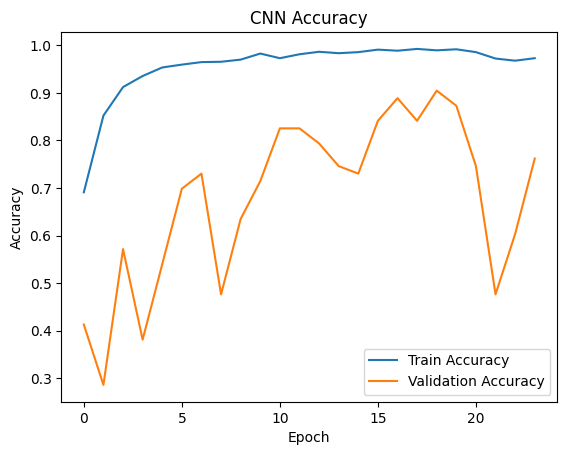

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 929ms/step
CNN Test Accuracy: 0.8816
CNN F1-score (Macro): 0.8837

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.76      0.98      0.86        52
     Powdery       0.98      0.86      0.91        50
        Rust       0.98      0.80      0.88        50

    accuracy                           0.88       152
   macro avg       0.90      0.88      0.88       152
weighted avg       0.90      0.88      0.88       152



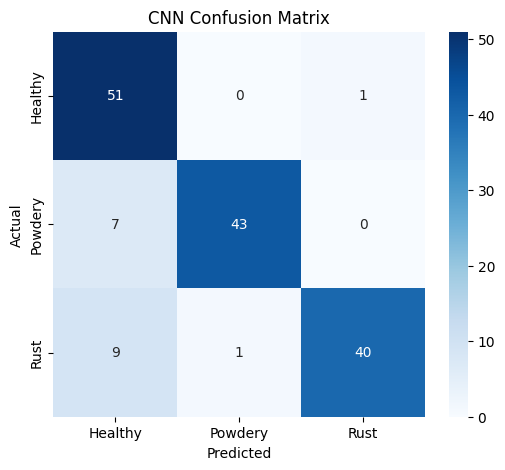

In [34]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print(f"CNN Test Accuracy: {accuracy:.4f}")
f1_macro = f1_score(y_true, y_pred, average='macro')
print(f"CNN F1-score (Macro): {f1_macro:.4f}")
print("\nClassification Report:")

class_names = sorted(test_df['label'].unique())
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


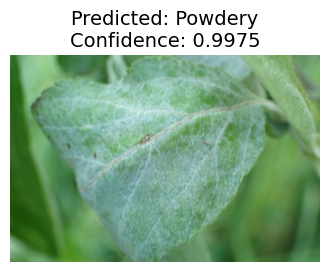

Predicted Class: Powdery | Confidence: 0.9975


In [41]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def preprocess_image(img_path, img_size=(128,128)):
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize(img_size)
    img_array = np.array(img_resized, dtype='float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def predict_and_show(img_path, model, class_names):
    img_array, original_img = preprocess_image(img_path)
    pred_probs = model.predict(img_array)
    pred_class = class_names[np.argmax(pred_probs)]
    confidence = np.max(pred_probs)


    plt.figure(figsize=(4,4))
    plt.imshow(original_img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}\nConfidence: {confidence:.4f}", fontsize=14)
    plt.show()

    return pred_class, confidence

img_path = '/content/drive/MyDrive/archive (2)/Test/Test/Powdery/80bc7d353e163e85.jpg'
class_names = sorted(test_df['label'].unique())
pred_class, confidence = predict_and_show(img_path, model, class_names)
print(f"Predicted Class: {pred_class} | Confidence: {confidence:.4f}")

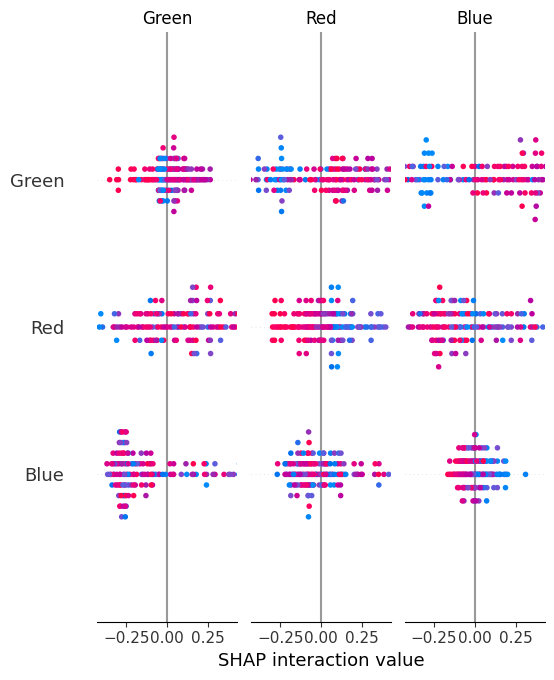

In [59]:
import shap
from pdpbox import pdp
import matplotlib.pyplot as plt

explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test_rf)

shap.summary_plot(shap_values_rf, X_test_rf, feature_names=['Red', 'Green', 'Blue'])


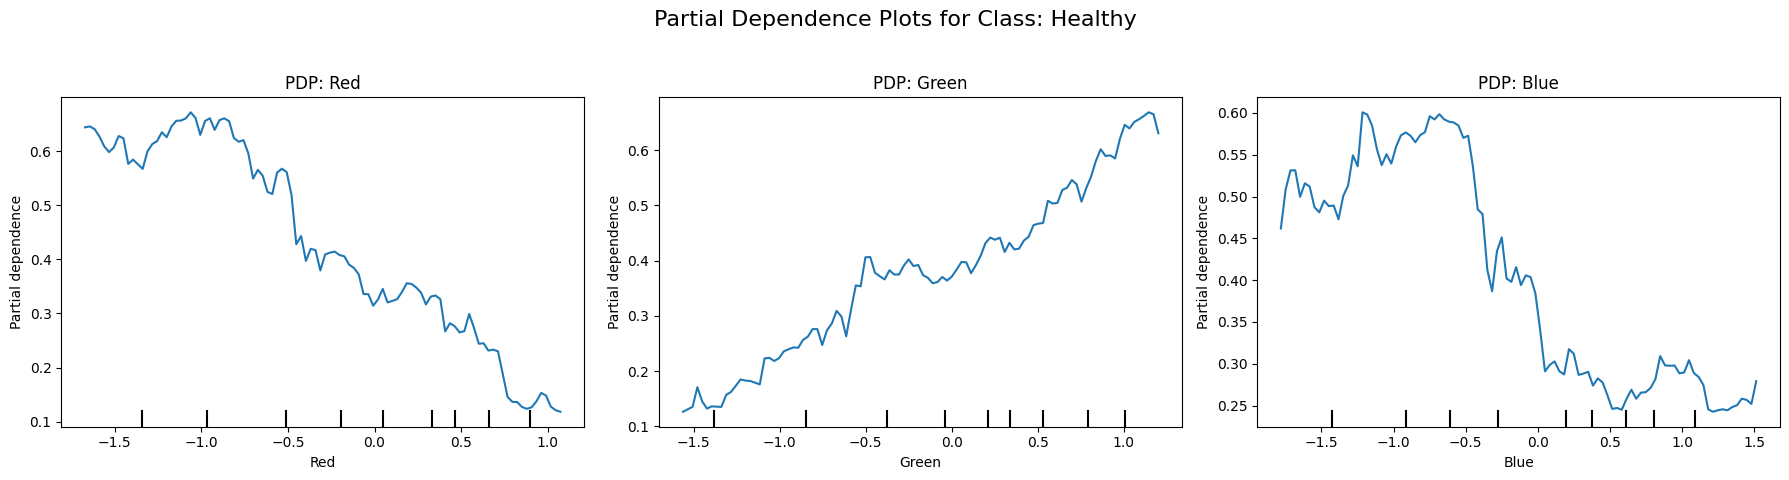

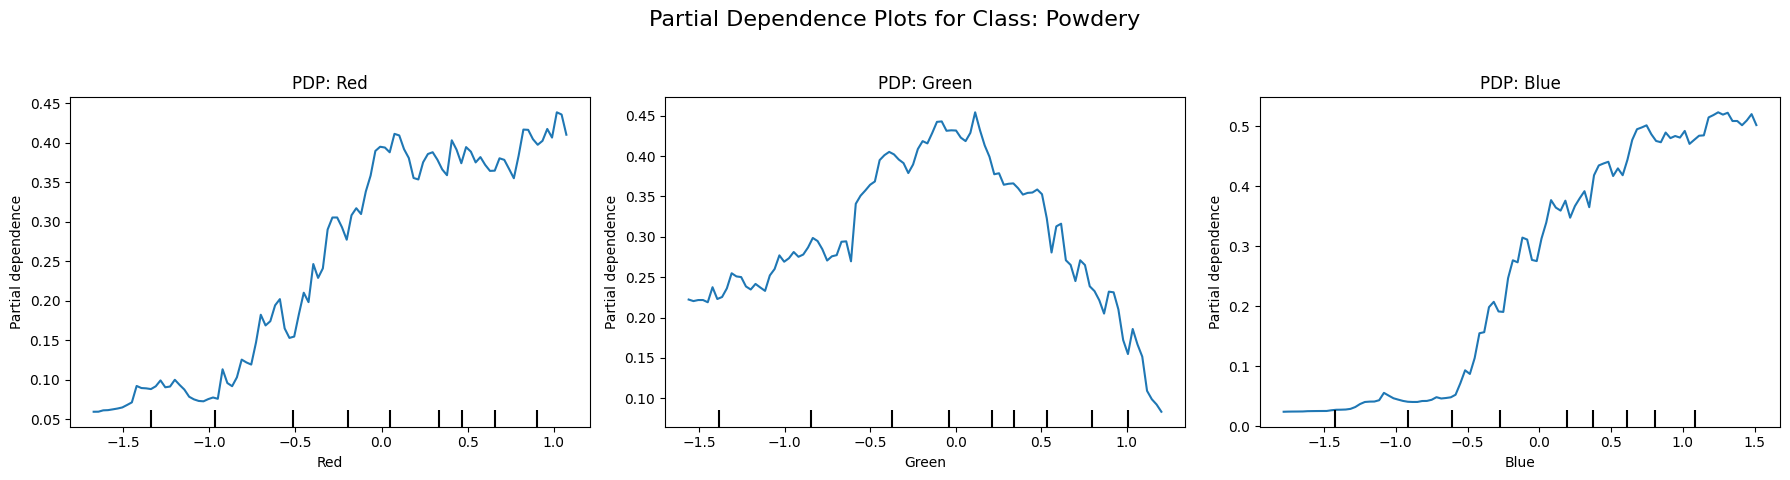

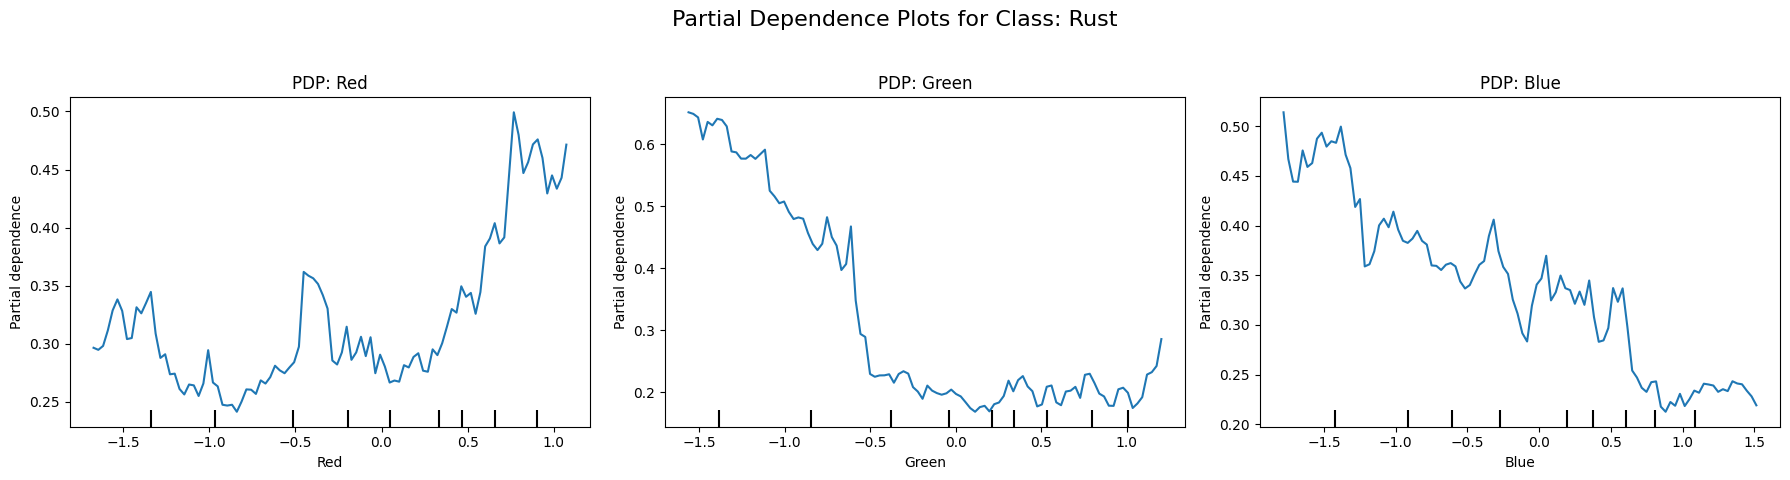

In [70]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = ['Red', 'Green', 'Blue']
class_names = sorted(le.classes_) # Get class names from the fitted LabelEncoder


for class_idx, class_name in enumerate(class_names):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Partial Dependence Plots for Class: {class_name}", fontsize=16)

    for i, feature in enumerate(features):
        PartialDependenceDisplay.from_estimator(
            rf_model,
            X_test_rf,
            features=[i],
            feature_names=features,
            target=class_idx, # Specify the target class index
            ax=ax[i]
        )
        ax[i].set_title(f"PDP: {feature}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

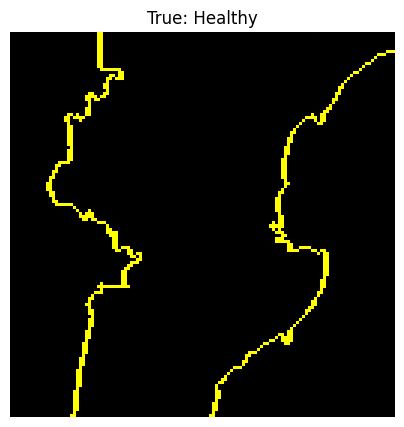

In [61]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt


explainer = lime_image.LimeImageExplainer()


for x_batch, y_batch in test_ds.take(1):
    img = x_batch[0].numpy()
    true_label = y_batch[0].numpy()
    break


explanation = explainer.explain_instance(
    image=img,
    classifier_fn=lambda x: model.predict(x),
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=true_label,
    positive_only=True,
    hide_rest=False
)


class_names = sorted(test_df['label'].unique())

plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(temp/255.0, mask))
plt.title(f"True: {class_names[true_label]}")
plt.axis('off')
plt.show()